# Asrun Bulk TOF Spectra Analysis: Raw data

Overview:   

Findings:   

NAMEOFUSER,   
EMAILOF USER   
DATE

---
This file was auto generated using the pyMAP db_analysis_generator.

In [1]:
import pandas as pd
import pyMAP as pm
from pyMAP.pyMAP.data.load import dat_loc
%matplotlib notebook

Import the asrun table

In [3]:
asrun = pm.data.asrun.load('../EMv2c_T011_PSPL_FirstLight_20230424_AsRun.xlsx',
                           page_names = ['EM_optics',
                                         'EM_tof',
                                         'Princeton_PSPL'
                                                    ]).reset_index().set_index('run_n')

Select for test runs with desired tags and apply that filter

In [7]:
asrun['Activity']

run_n
1                            MCP ramp
2                            PAC Ramp
3                            PAC Ramp
4                            PAC Ramp
5                          Drk Counts
                   ...               
67               Scattering Electrons
68    Scattering Electrons Drk counts
69                        ToF Spectra
70                        ToF Spectra
71                         Drk Counts
Name: Activity, Length: 71, dtype: object

In [8]:
locater = np.logical_and.reduce([asrun['Activity'].str.lower().str.contains('scattering electrons').values,
                                 asrun['species'].values == 'O',
#                                  asrun['heml_on'].values == 0
                                ])

asrun= asrun.iloc[locater]

## Load and Process DE Data

load direct event data

In [2]:
pm.data.asrun.import_em_data(asrun,home = '../Test Data/Sensor/csv')
# Drop the cells without data
asrun.dropna(subset = ['ILO_RAW_DE'],axis = 0,inplace = True)

NameError: name 'asrun' is not defined

apply cleaning and filtering to raw data. set desired tags 

- remove_delay (True):Converting from raw time of to time of flight using signal technique
- filt_triples (True): Weather or not to select for all valid tofs
- checksum (float): all checksum values with magnitute > checksum are discarded
- not filtering speed

In [110]:
deData = asrun.set_index(['E_step','beam_ke','pac','heml_on'],append = True).apply(lambda x:pm.tof.clean(x['ILO_RAW_DE'],
                                                              remove_delay = True,
                                                              filt_triples = True,
                                                              checksum = 1,
                                                              filt_speed = False,
                                                              remove_delay_input = {'mcp_v':x['mcp_v']}
                                                                                                ),axis = 1)
deData.name = 'ILO_RAW_DE'
# deData = asrun.set_index(['E_step','beam_ke','pac'],append = True)['ILO_RAW_DE'].dropna()

##  Direct Event Spectra Plotting

Next we plot the 1d spectra overlayed according to indexes asigned above

<IPython.core.display.Javascript object>


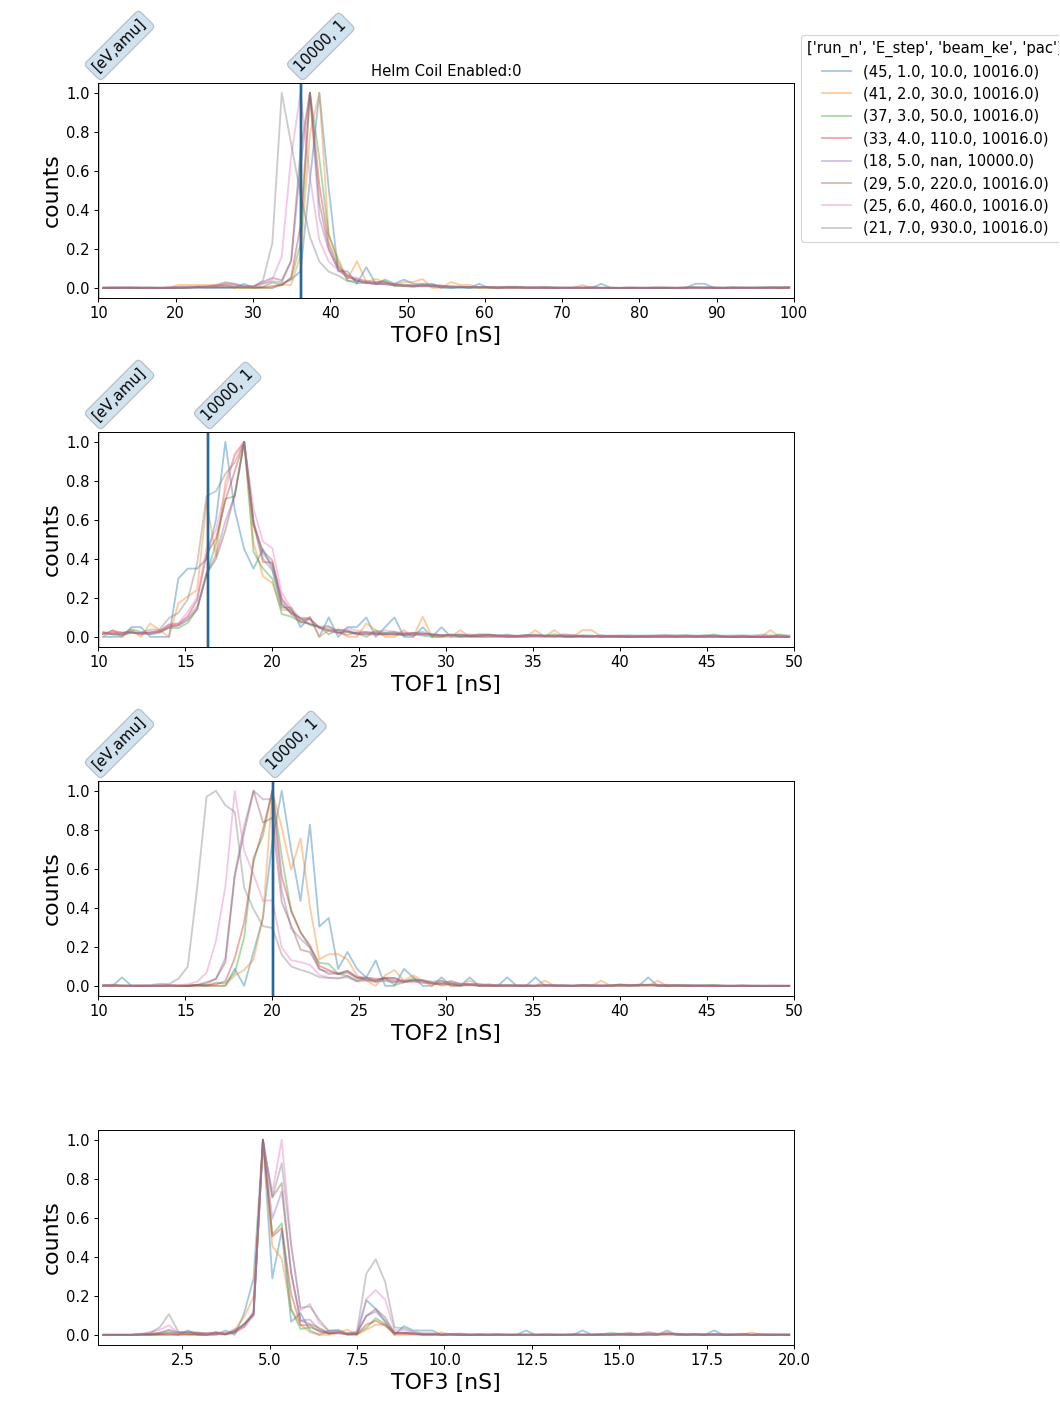

<IPython.core.display.Javascript object>


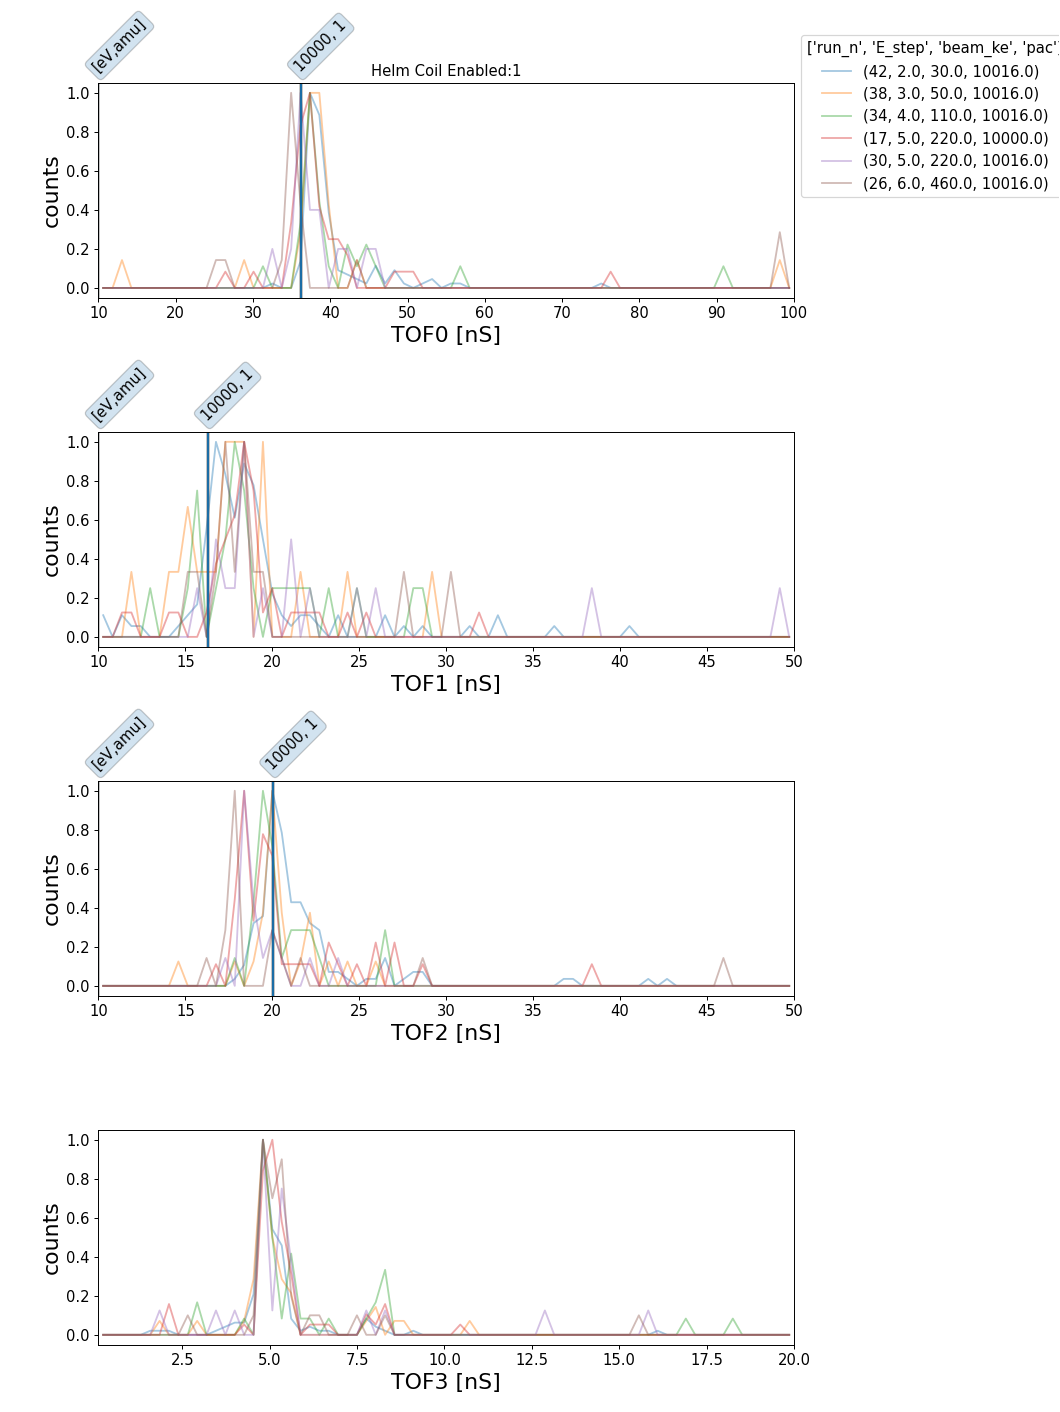

""


In [154]:
def pltr1d(data):
    fig,axs = pm.plt.tofs_1d(data['ILO_RAW_DE'],
                                 bins = 75,
                                bin_range = {'TOF0': [10,100],
                                            'TOF1':[10,50],
                                            'TOF2':[10,50],
                                            'TOF3':[.1,20]},
                                tof_ref_lines = {'species':['H'],'ke':10000},
                             logbins = False,
                   norm = 'max'
                  )
    pm.bowPy.plotJon.legend.legend_loc(fig = fig,ax = axs[0],label = deData.reset_index('heml_on').index.names)
    axs[0].set_title('Helm Coil Enabled:%d'%data.name)
deData.reset_index('heml_on').groupby('heml_on').apply(pltr1d)

### Comments:
We can see for both the Helm Coil modes that there is a noticible shift to shorter times of flight which increases with energy step. We expect such a variation assocated with the incident beam energy, but it is possible we could also be seeing additional shift brought in from acceleration of some incident ions to the CS. 


## TOF Peak Locations
take the direct events, bin them in 1d, interpolate those spectra and identify the resulting peak location

In [112]:
deData.sort_index(level = 'E_step',inplace = True)
deData = deData.loc[deData.apply(len)>0]

In [140]:
tof_peaks = deData.apply(lambda x:pm.tof.fit_tofs(x,
                    tof_ranges = {'TOF0':[0,100],
                                 'TOF1':[0,40],
                                 'TOF2':[0,50],
                                 'TOF3':[0,16]},bin_ns = 1).apply(lambda x: x.find_xy(find = 'peak'))
                        )
tof_peaks['n'] = deData.apply(len)

the resulting peak locations:

In [141]:
tof_peaks

,,,,,TOF0,TOF1,TOF2,n
run_n,E_step,beam_ke,pac,heml_on,,,,
45,1.0,10.0,10016.0,0.0,38.695012,17.486009,21.025845,139
41,2.0,30.0,10016.0,0.0,38.285012,17.825873,20.785895,199
42,2.0,30.0,10016.0,1.0,38.315012,17.705921,20.515953,138
37,3.0,50.0,10016.0,0.0,37.825012,17.945824,19.986065,1150
38,3.0,50.0,10016.0,1.0,38.165012,17.785889,20.116038,43
33,4.0,110.0,10016.0,0.0,37.595013,17.955820,19.896085,32640
34,4.0,110.0,10016.0,1.0,37.015013,17.725913,19.876089,40
17,5.0,220.0,10000.0,1.0,36.925013,18.025792,19.136246,69
18,5.0,NaN,10000.0,0.0,37.055013,18.085768,19.306210,7311


# Peak location variation with Estep. 

Next we take the peak locations Identified from the cells above and plot them as a function of energy step.

<IPython.core.display.Javascript object>


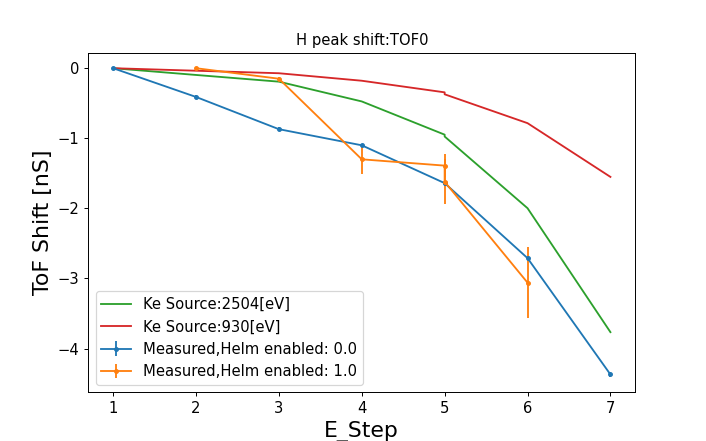

<IPython.core.display.Javascript object>


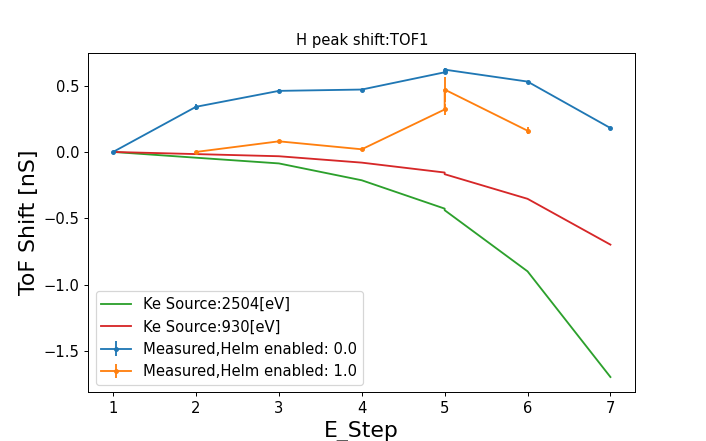

<IPython.core.display.Javascript object>


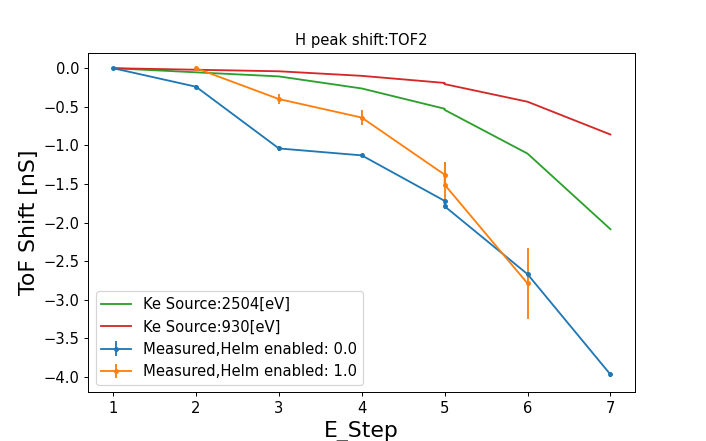

In [156]:
def pltr(peaks):
    fig,ax = plt.subplots()
    fig.set_size_inches(8,5)
    shift = peaks[tf].values
    err = shift/np.sqrt(peaks['n'].values)
    ax.errorbar(peaks.index,shift,shift_err,fmt = '.-')

tof_peaks.reset_index().set_index('E_step').groupby('heml_on').apply(pltr)
ax.set_xlabel('E_Step')
ax.set_ylabel('ToF Shift [nS]')
ax.set_title('H peak shift:%s'%tf)
ax.legend()

# Conclusion

- See clear shifts to shorter times of flight in TOF0 and TOF2, no variation observed in TOF1 for changes in the instrument estep. 
    - this isnt entirely surprising because ToF1 is after energy loss through both foils, still a little weird though. 
- Here we can see that there are clear systematic shifts with similar magnitudes for both modes of the Helm coil. Seems to indicate that the population of particles we are looking at in both modes is the same. 
    - At the lower energy steps we do see a smaller positive shift so this could just be a problem with statistics. 
- Still clearly seeing a large shift of TOF2 to lower times of flight, as was observed with the previous round of testing with emv2 at princeton, an exact calculation should be run, but these still seem too large of a shift to be driven by a physical process. 

love,   
Jon